In [15]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Scapy Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.2 anndata==0.7.8 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2


In [16]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    './example/data/filtered_gene_bc_matrices/hg19/',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)


... reading from cache file cache\example-data-filtered_gene_bc_matrices-hg19-matrix.h5ad



### scPhere

it has its own data input and doesn't use adata from scanpy

In [17]:
adata = sc.read_mtx('./example/data/filtered_gene_bc_matrices/hg19/matrix.mtx')

# Access sparse matrix 
x = adata.X 

# Convert to dense matrix
x = x.toarray() 

# Transpose
x = x.T

print(x.shape)
print(type(x))

(2700, 32738)
<class 'numpy.ndarray'>


In [18]:
from scphere.util.util import read_mtx
from scphere.util.trainer import Trainer
from scphere.model.vae import SCPHERE
from scphere.util.plot import plot_trace

In [19]:
# If no batch information is available
n_samples = x.shape[0]
batch = np.zeros(n_samples)  # Artificial batch vector

In [20]:
# Update model with latent dimension of 10 and no batch information
model = SCPHERE(n_gene=x.shape[1], n_batch=0,
                z_dim=9, latent_dist='vmf', batch_invariant=False, 
                observation_dist='nb', seed=0)

trainer = Trainer(model=model, x=x, batch_id=batch, max_epoch=250,
                  mb_size=128, learning_rate=0.001)

trainer.train()

0 / 5250 {'Log-likelihood': -7914.368, 'ELBO': -7914.505, 'KL': 0.13691393}
50 / 5250 {'Log-likelihood': -4183.4756, 'ELBO': -4186.1235, 'KL': 2.6481333}
100 / 5250 {'Log-likelihood': -3047.1614, 'ELBO': -3052.1748, 'KL': 5.013499}
150 / 5250 {'Log-likelihood': -2926.1875, 'ELBO': -2932.204, 'KL': 6.0167093}
200 / 5250 {'Log-likelihood': -2958.6914, 'ELBO': -2965.3037, 'KL': 6.612221}
250 / 5250 {'Log-likelihood': -2919.746, 'ELBO': -2926.6814, 'KL': 6.93522}
300 / 5250 {'Log-likelihood': -2935.9453, 'ELBO': -2943.0823, 'KL': 7.1368594}
350 / 5250 {'Log-likelihood': -2973.369, 'ELBO': -2980.6719, 'KL': 7.3030915}
400 / 5250 {'Log-likelihood': -2943.6162, 'ELBO': -2951.0073, 'KL': 7.391115}
450 / 5250 {'Log-likelihood': -2898.3071, 'ELBO': -2905.7507, 'KL': 7.443553}
500 / 5250 {'Log-likelihood': -2953.1636, 'ELBO': -2960.6296, 'KL': 7.4660363}
550 / 5250 {'Log-likelihood': -2921.6628, 'ELBO': -2929.1375, 'KL': 7.474721}
600 / 5250 {'Log-likelihood': -2861.8652, 'ELBO': -2869.346, 'KL':

Embedding saved to ./example/output/embedding.csv


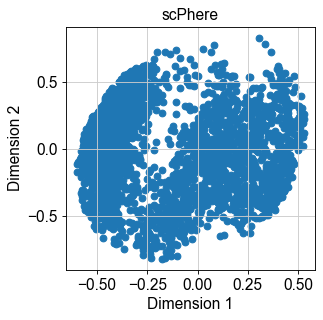

In [21]:
# Save the trained model and embeddings
save_path = './example/output/'
model_name = save_path + 'model_250epoch'
model.save_sess(model_name)

z_mean = model.encode(x, batch)
np.savetxt(save_path + 'latent_250epoch.tsv', z_mean)

z_vis = z_mean[:, :2]

# Plotting
plt.figure()
plt.scatter(z_vis[:, 0], z_vis[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('scPhere')
plt.savefig(save_path + 'embedding_visualization.png')

embedding_df = pd.DataFrame(z_vis, columns=['Dimension 1', 'Dimension 2'])
embedding_df.to_csv(save_path + 'embedding.csv', index=False)
print('Embedding saved to ' + save_path + 'embedding.csv')

In [22]:
# Print the data type of z_mean
print("Data type of z_mean:", z_mean.dtype)

# Convert z_mean to a DataFrame and save as CSV
z_mean_df = pd.DataFrame(z_mean)
# Assuming zmean is your DataFrame
z_mean_df.rename(columns={0: 'Dimension_0',1: 'Dimension_1', 2: 'Dimension_2', 3: 'Dimension_3', 
                      4: 'Dimension_4', 5: 'Dimension_5', 6: 'Dimension_6', 
                      7: 'Dimension_7', 8: 'Dimension_8', 9: 'Dimension_9'}, inplace=True)

z_mean_df.to_csv(save_path + 'z_mean.csv', index=False)
print('z_mean saved to ' + save_path + 'z_mean.csv')

Data type of z_mean: float32
z_mean saved to ./example/output/z_mean.csv


In [23]:
z_mean_df.shape

(2700, 10)